In [29]:
from numpy import genfromtxt
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import normalize
import sklearn.datasets as ds
import sklearn.model_selection as ms
import sklearn.svm as svm
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
import shap

In [30]:
gesture = ['Down', 'Up', 'Left', 'Right']
# gesture = ['Left', 'Right']
path = 'HeadData/'
gyro = '/gyro/'
features = 6
trials = 40
x = [[0] * features for i in range(trials*len(gesture))]
y = [0] * trials*len(gesture) 

In [31]:
def min_max_feature_order(s1,s2):
    if (s1>s2): 
        return 1
    else:
        return 5

In [32]:
for i in range(0,len(gesture),1):
    for k in range(0,trials,1):
        path_data = path+ gesture[i]+ gyro +'trial'+str(k+1)+'.csv'
        data = genfromtxt(path_data, delimiter=',')
        #Features
        x[k+i*trials][0]=min_max_feature_order(np.argmax(data[:,1]), np.argmin(data[:,1]))
        x[k+i*trials][1]=min_max_feature_order(np.argmax(data[:,3]), np.argmin(data[:,3]))
        x[k+i*trials][2]=min_max_feature_order(np.argmax(data[:,2]), np.argmin(data[:,2]))
        x[k+i*trials][3]=min(data[:,1]) # down up gestures the x dimension changes the most
        x[k+i*trials][4]=min(data[:,3]) # right left gestures the z dimension changes the most
        x[k+i*trials][5]=min(data[:,2]) 
        # x[k+i*trials][4]=max(data[:,1]) # down up gestures the x dimension changes the most
        # x[k+i*trials][5]=max(data[:,3]) # right left gestures the z dimension changes the most
        # x[k+i*trials][6]=data[:,1].mean() # mean for x dimension
        # x[k+i*trials][7]=data[:,3].mean() # mean for z dimension
        # x[k+i*trials][8]=data[:,1].std() # std for x dimension
        # x[k+i*trials][9]=data[:,3].std() # std for z dimension
        #target variables
        y[[k+i*trials][0]]=i

In [33]:
# Split dataset into training set and test set 
# 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(x , y, test_size=0.25) 

In [34]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)        

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


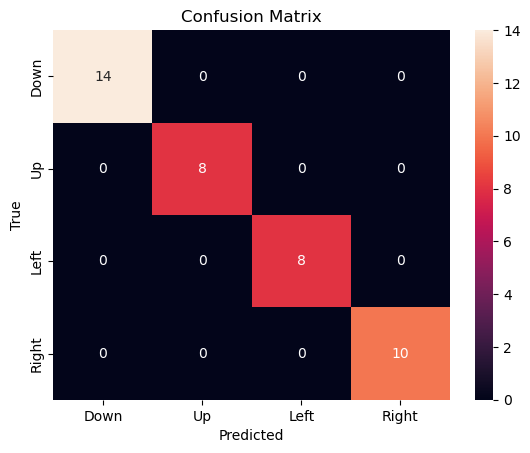

In [35]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,  average='micro'))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=gesture, columns=gesture)
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

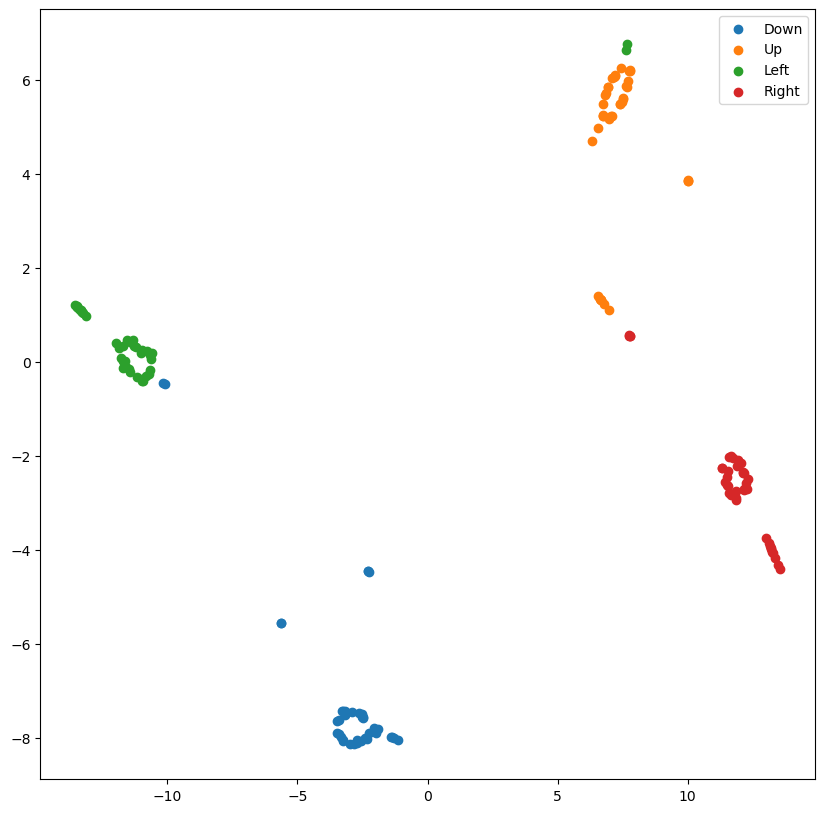

In [42]:
tsne = TSNE(n_components=2)
X_normalized = normalize(np.array(x), axis=0, norm='max')
X_embedded = tsne.fit_transform(X_normalized)
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[np.array(y) == 0, 0], X_embedded[np.array(y) == 0, 1], label=target_names[0])
plt.scatter(X_embedded[np.array(y) == 1, 0], X_embedded[np.array(y) == 1, 1], label=target_names[1])
plt.scatter(X_embedded[np.array(y) == 2, 0], X_embedded[np.array(y) == 2, 1], label=target_names[2])
plt.scatter(X_embedded[np.array(y) == 3, 0], X_embedded[np.array(y) == 3, 1], label=target_names[3])
plt.legend()
plt.show()

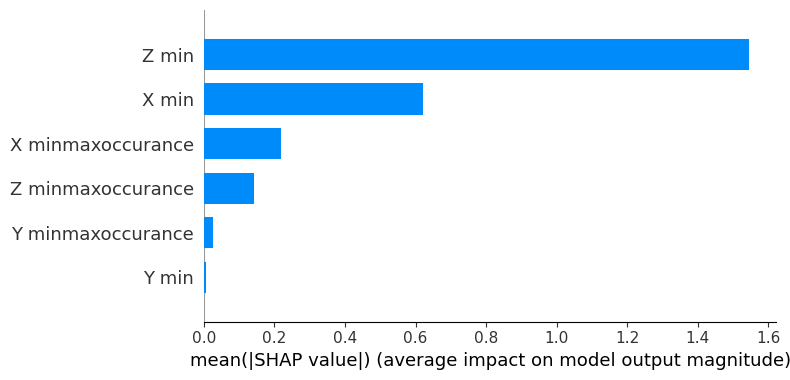

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x , y, test_size=0.25, random_state=0) 

clf = svm.SVC(kernel='linear') 
clf.fit(np.array(X_train), np.array(y_train))

explainer = shap.Explainer(clf, np.array(X_train))
shap_values_individual = explainer.shap_values(np.array(X_test))
shap_values = sum(shap_values_individual)/len(shap_values_individual)
feature_names = ['X minmaxoccurance', 'Z minmaxoccurance', 'Y minmaxoccurance', 'X min', 'Z min', 'Y min']
target_names = ['Down', 'Up', 'Left', 'Right']

shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=target_names, feature_names=feature_names)
